# Group 4 Assignment 2 

### Authors: 
-  Chin Yee Wan 
-  Darrel Koh
-  Nguyen Gia Khanh 
-  Ngo Vu Anh	

### Main Steps
1.  Data Preprocessing 
-   Read in as SPARK dataframe for data preprocessing
-   Convert to Pandas dataframe for data exploration
2.  Data Exploration
3.  Data Modelling
4.  Data Evaluation

# Discover and Visualise the Data

## Import Libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from imblearn.over_sampling import SMOTE


from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from sklearn.metrics import confusion_matrix, classification_report

## Functions definition 

### Read in file

In [2]:
train_df = pd.read_csv('GA2Datasets/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('GA2Datasets/UNSW_NB15_testing-set.csv')

In [3]:
spark = SparkSession.builder \
                            .appName("CSCI316GP2")\
                            .config("spark.sql.files.maxPartitionBytes", "1000000")\
                            .getOrCreate()

23/08/17 15:23:22 WARN Utils: Your hostname, Darrels-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.33.24.180 instead (on interface en0)
23/08/17 15:23:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/17 15:23:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark_df = spark.createDataFrame(train_df)
spark_df.show()

23/08/17 15:23:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/08/17 15:23:36 WARN TaskSetManager: Stage 0 contains a task of very large size (1416 KiB). The maximum recommended task size is 1000 KiB.


+---+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+----------+-----+
| id|   dur|proto|service|state|spkts|dpkts|sbytes|dbytes|       rate|sttl|dttl|        sload|dload|sloss|dloss|   sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|smean|dmean|trans_depth|response_body_len|ct_srv_src|ct_state_ttl|ct_dst_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|ct_src_ltm|ct_srv_dst|is_sm_ips_ports|attack_cat|label|
+---+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+--

#### Custom pipeline for data pre-processing

In [5]:
class PreProcessPipeline:
    def __init__(self, label_encode = True, process_label = 'Binary', smote = False):
        self.label_encode = label_encode
        self.process_label = process_label
        self.smote = smote
    
    def fit(self):
        return self

    def transform(self, df):
        df = df.drop('id', axis=1)
        df = df.copy()
        if self.label_encode:
            columns = ['proto', 'service', 'state', 'attack_cat']
            for column in columns:
                unique_values = df[column].unique()
                mapping = {value: index for index, value in enumerate(unique_values)}
                df[column] = df[column].map(mapping)

        if self.process_label == 'Binary':
            df.drop('attack_cat', axis=1, inplace=True)
        else:             
            df['attack_cat'], df['label'] = df['label'], df['attack_cat']
            df.drop('attack_cat', axis=1, inplace=True)   

        if self.smote:
            # Separate features and labels
            X = df.drop('label', axis=1)
            y = df['label']

            # Apply SMOTE for oversampling
            smote = SMOTE(sampling_strategy='auto', random_state=42)
            X_resampled, y_resampled = smote.fit_resample(X, y)

            # Convert NumPy arrays back to Pandas DataFrames
            X_resampled_df = pd.DataFrame(data=X_resampled, columns=X.columns)
            y_resampled_df = pd.DataFrame(data=y_resampled, columns=['label'])

            # Concatenate the features and label columns into a single DataFrame
            df = pd.concat([X_resampled_df, y_resampled_df], axis=1)     

        return df

#### Dataframe Pipeline

In [6]:
'''
Author: Khanh Nguyen
Name: PySpark Dataframe Pipeline
Description:
    This class is used to create a pipeline for PySpark dataframe, accept 2 boolean parameter: smote & standardize.
    Features 
        (Default)
        - Resample: Resample the dataframe
        - Vectorize: Vectorize the dataframe
        (activate by setting the parameter to True):
        - SMOTE: Oversampling the minority class
        - Standardize: Standardize the dataframe using z-score
'''
class SparkDFPipeline:
    def __init__(self, standardize=False):
        self.standardize = standardize
    
    def fit(self):
        return self
    
    def transform(self, train_df, test_df):      
        if self.standardize:
            # Standardize the df

            # Resample the df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)

            exclude = ['proto', 'service', 'state']
            input_columns = train_df.columns[:-1]
            selected_columns = [col for col in input_columns if col not in exclude]
            # Vectorize the df
            assembler = VectorAssembler(inputCols=selected_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            test_df = assembler.transform(test_df)

            # Standardize the df
            scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
            scaler_model = scaler.fit(train_df)
            train_df = scaler_model.transform(train_df)

            scaler_model = scaler.fit(test_df)
            test_df = scaler_model.transform(test_df)
            test_df = test_df.drop('features')
            train_df = train_df.drop('features')
            
            # put back the categorical columns
            input_cols = ['scaled_features', 'proto', 'service', 'state']
            output_col = "features"
            assembler1 = VectorAssembler(inputCols=input_cols, outputCol=output_col)
            train_df = assembler1.transform(train_df)
            test_df = assembler1.transform(test_df)

            # return result
            test_df = test_df.select('features', 'label')
            train_df = train_df.select('features', 'label')
        else:
            # Normal vectorize df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)
            input_columns = train_df.columns[:-1]
            assembler = VectorAssembler(inputCols=input_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            train_df = train_df.select('features', 'label')
            test_df = assembler.transform(test_df)
              
        return train_df, test_df

### For Logistic Regression

In [7]:
def train_weighted_logistic_regression(train_df):
    # Calculate class frequencies
    class_frequencies = train_df.groupBy("label").count()

    # Calculate class weights
    total_samples = train_df.count()
    class_frequencies = class_frequencies.withColumn("weight", total_samples / (class_frequencies["count"] * class_frequencies.count()))

    # Join the weights with the training data
    train_with_weights = train_df.join(class_frequencies, on="label")

    # Add a constant column for weight if it doesn't exist
    if "weight" not in train_with_weights.columns:
        train_with_weights = train_with_weights.withColumn("weight", lit(1.0))

    # Create a VectorAssembler
    assembler = VectorAssembler(inputCols=['features'], outputCol='assembled_features')

    # Define the Logistic Regression model with class weights
    lr_weighted = LogisticRegression(featuresCol='assembled_features', labelCol='label', maxIter=10, weightCol='weight')

    # Create a pipeline with the defined stages
    pipeline_weighted = Pipeline(stages=[assembler, lr_weighted])

    # Fit the pipeline on your training data with class weights
    model_weighted = pipeline_weighted.fit(train_with_weights)
    
    return model_weighted

#### For Visualisation

In [8]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

#### For Evaluation

In [9]:
def evaluate_model(model, val_data, model_name):
    # Make predictions on the validation data
    predictions = model.transform(val_data)

    # Evaluate the model using a BinaryClassificationEvaluator for AUC
    auc_evaluator = BinaryClassificationEvaluator(labelCol='label')
    auc = auc_evaluator.evaluate(predictions)

    # Evaluate the model using a BinaryClassificationEvaluator for areaUnderPR
    pr_evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderPR')
    area_under_pr = pr_evaluator.evaluate(predictions)

    # Calculate additional metrics
    sensitivity = predictions.filter("label = 1 and prediction = 1").count() / predictions.filter("label = 1").count()
    specificity = predictions.filter("label = 0 and prediction = 0").count() / predictions.filter("label = 0").count()
    precision = predictions.filter("prediction = 1").count() / predictions.filter("prediction = 1 or prediction = 0").count()
    recall = sensitivity
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (predictions.filter("label = prediction").count()) / predictions.count()
    # youdens_j = sensitivity + specificity - 1
    # balanced_accuracy = (sensitivity + specificity) / 2

    # Convert Spark DataFrames to Pandas DataFrames for visualization
    y_true_pd = predictions.select('label').toPandas()
    y_pred_pd = predictions.select('prediction', 'probability').toPandas()
    
    # Convert prediction probabilities to binary predictions
    y_pred_binary = [1 if prob[1] >= 0.5 else 0 for prob in y_pred_pd['probability']]

    # Generate the confusion matrix
    cm = confusion_matrix(y_true_pd['label'], y_pred_binary)

    # Display the confusion matrix as a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-default', 'Default'], 
                yticklabels=['Non-default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(model_name)
    plt.show()


    # Create a dictionary of model evaluation metrics
    eval_metrics = {
        'AUC': auc,
        'AreaUnderPR': area_under_pr,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'Accuracy': accuracy,
        # "Youden's J Index": youdens_j,
        # 'Balanced Accuracy': balanced_accuracy
    }

    return eval_metrics


# # Sample usage 
# # Evaluate models using the evaluate_model function
# evaluation_results_default = evaluate_model(model_default, test, 'Default Model')  # Use the 'test' dataset

# # Evaluate models using the evaluate_model function
# evaluation_results_tuned = evaluate_model(model_tuned, FT_test, 'Fine-Tuned Model')  # Use the 'test' dataset

# # Print evaluation results for both models side by side

# print("Evaluation Results:")
# print(f"{'Metric':<20}{'Default Model':<20}{'Fine-Tuned Model':<20}")
# print("=" * 60)

# for metric in evaluation_results_default.keys():
#     default_value = evaluation_results_default[metric]
#     tuned_value = evaluation_results_tuned[metric]
#     print(f"{metric:<20}{default_value:<20}{tuned_value:<20}")

## Data Exploration

### Explore train_df 

In [10]:
train_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [11]:
# pipeline = PreProcessPipeline(label_encode=True, process_label='Multi')
# train_df = pipeline.transform(train_df)
# test_df = pipeline.transform(test_df)
pipeline_train = PreProcessPipeline(label_encode=True, process_label='Binary')
pipeline_test = PreProcessPipeline(label_encode=True, process_label='Binary')
train_df = pipeline_train.transform(train_df)
test_df = pipeline_test.transform(test_df)

## Data Visualisation

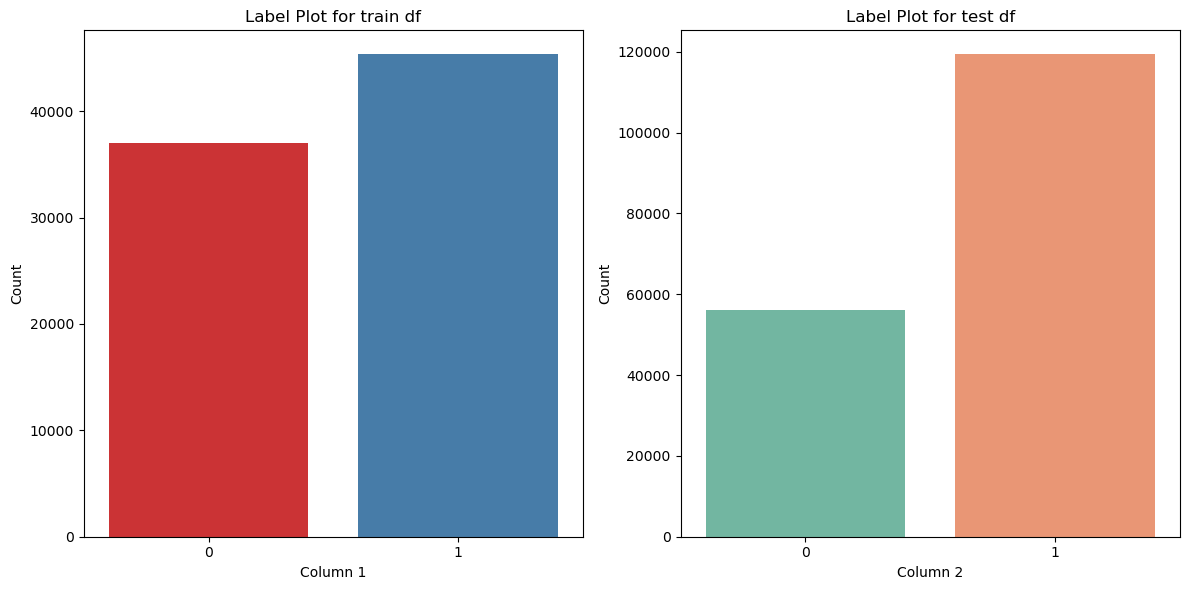

In [12]:
# Set up the figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot countplot for column1
sns.countplot(data=train_df, x='label', palette="Set1", ax=axes[0])
axes[0].set_title("Label Plot for train df")
axes[0].set_xlabel("Column 1")
axes[0].set_ylabel("Count")

# Plot countplot for column2
sns.countplot(data=test_df, x='label', palette="Set2", ax=axes[1])
axes[1].set_title("Label Plot for test df")
axes[1].set_xlabel("Column 2")
axes[1].set_ylabel("Count")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

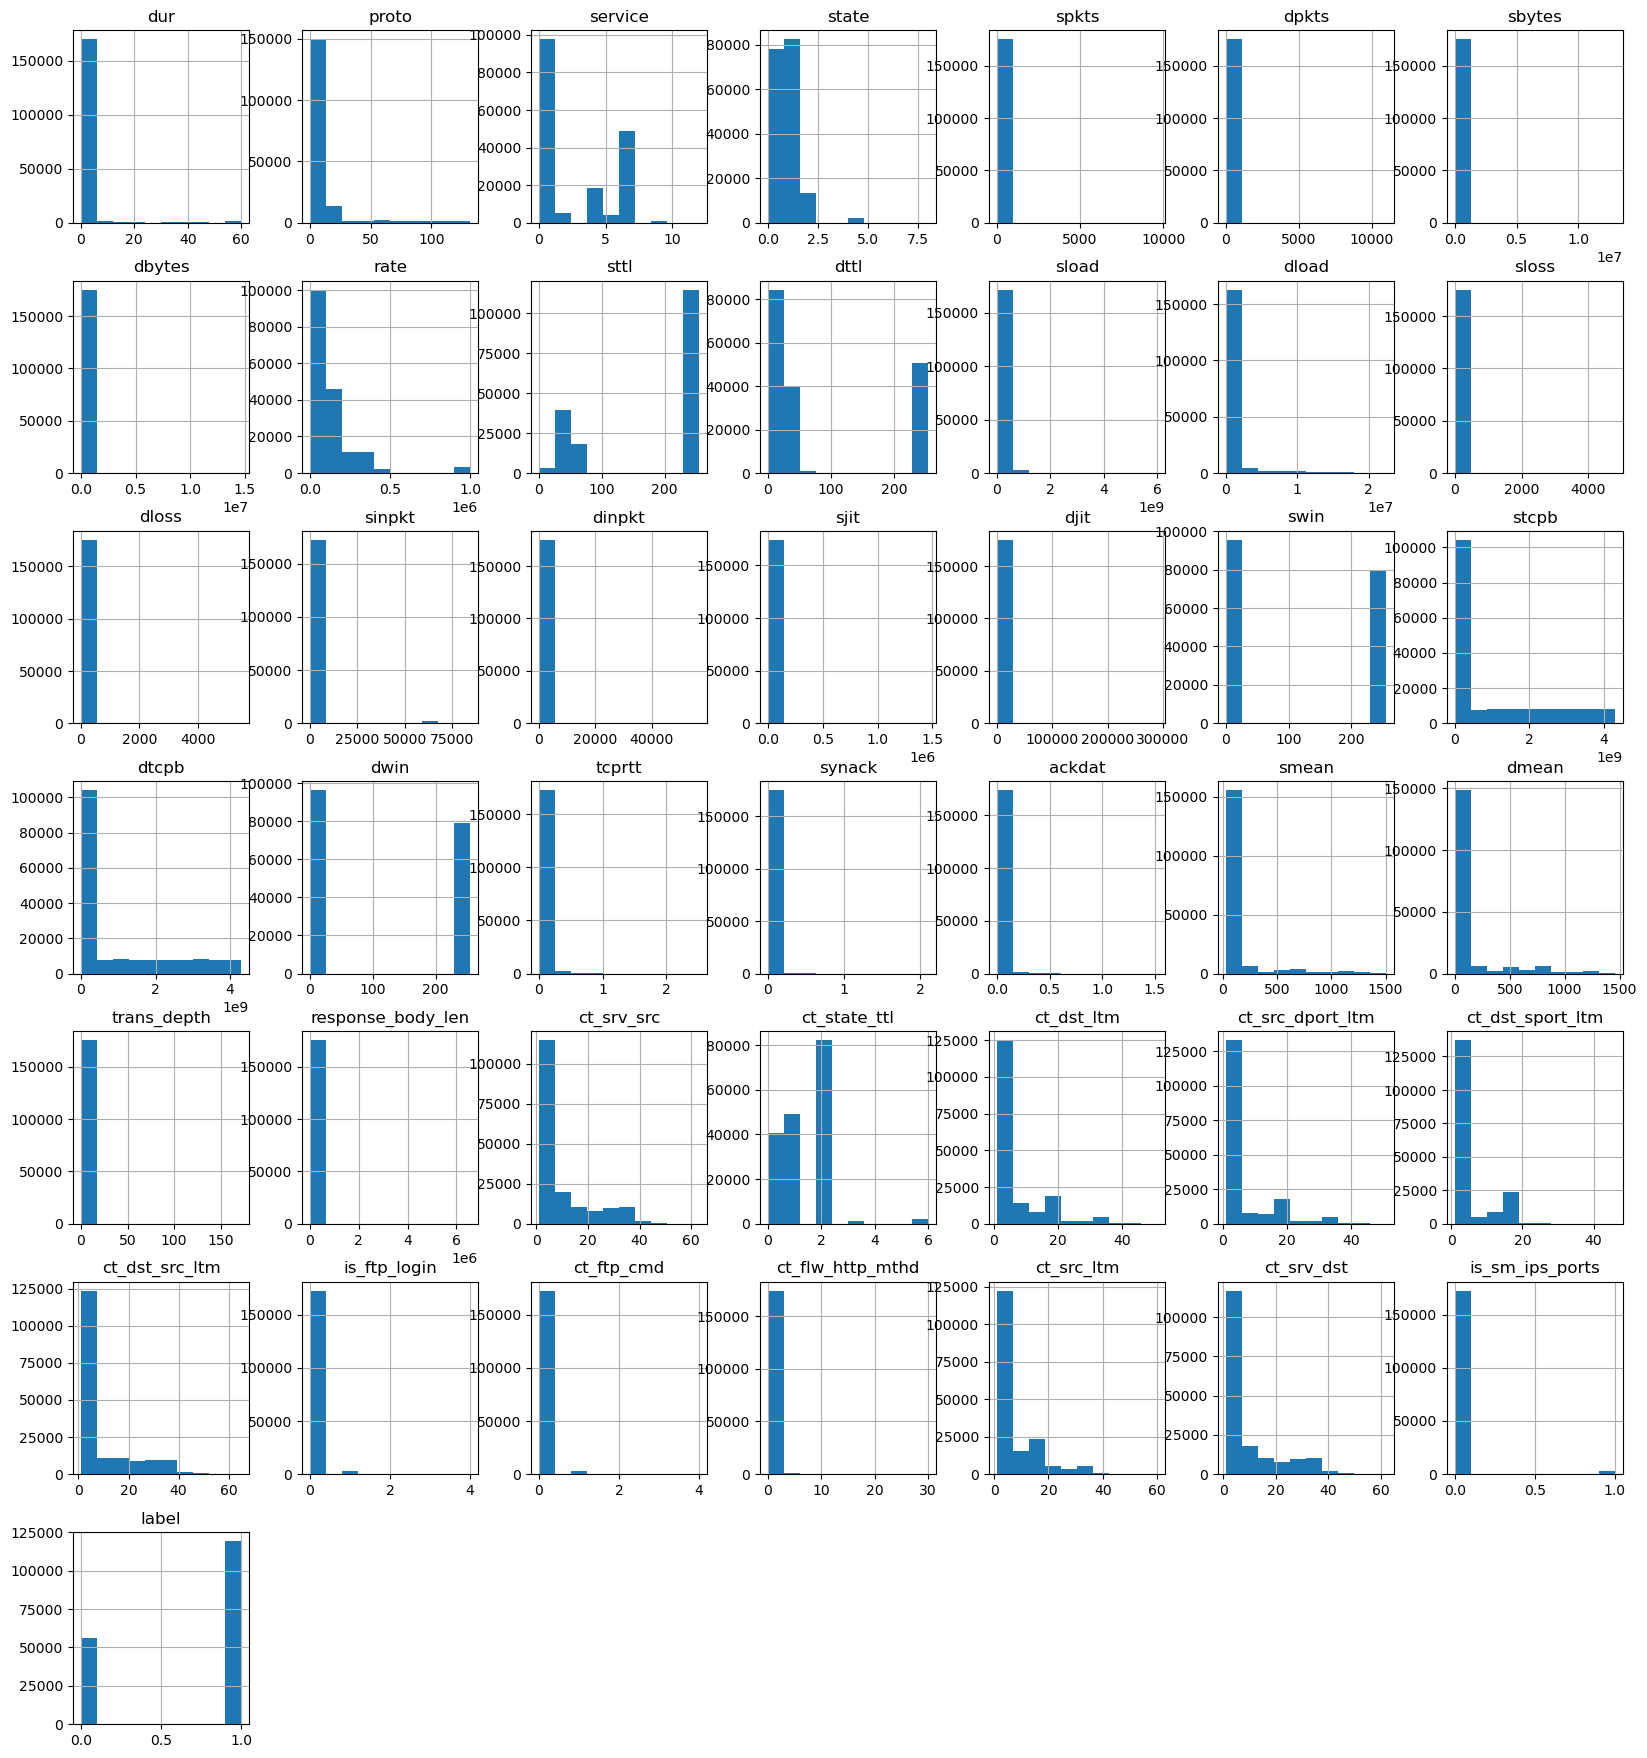

In [13]:
rcParams["figure.figsize"]=(20,22)
train_df.hist()
plt.grid()

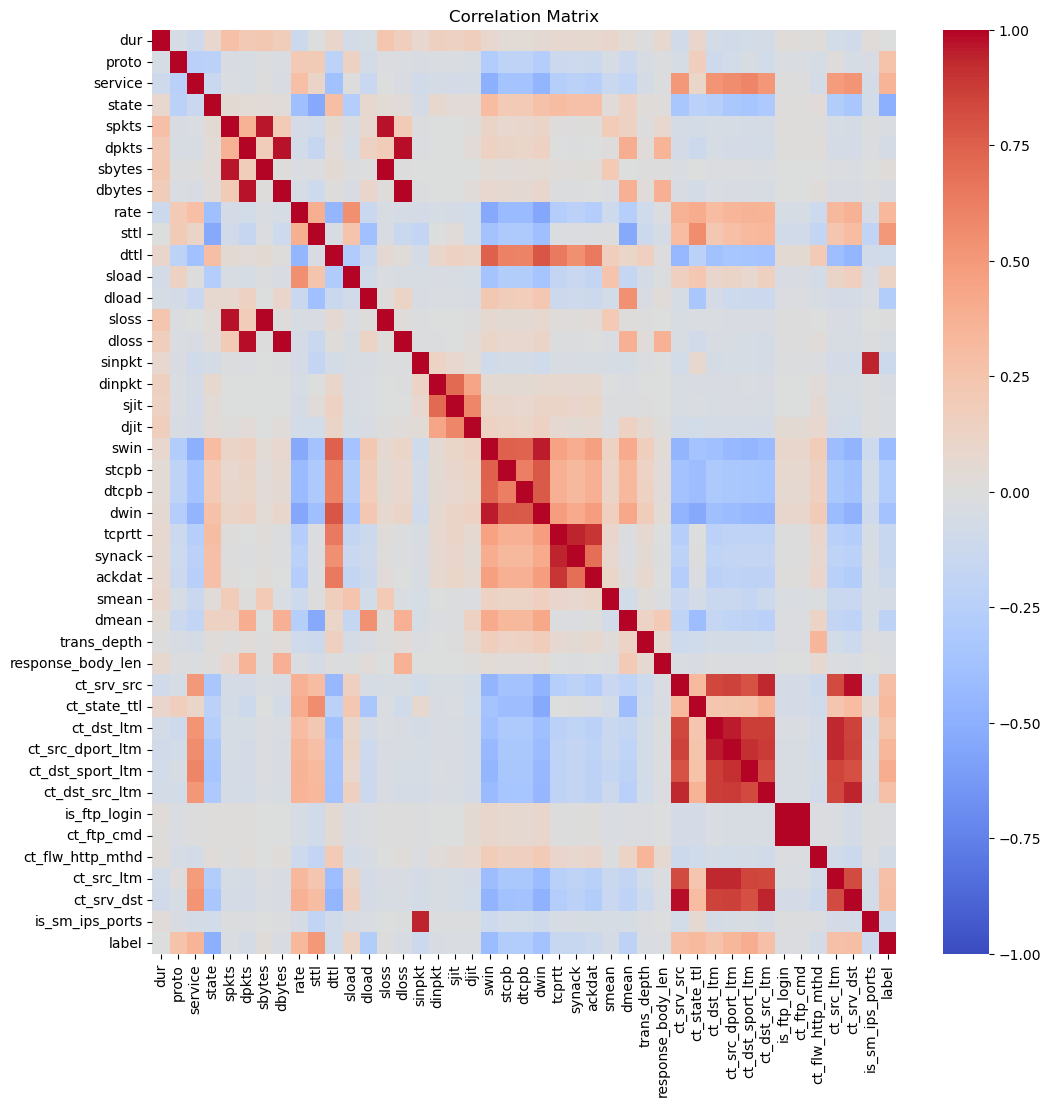

In [14]:
# Visualize - Correlation matrix

# Create a correlation matrix
corr_matrix = train_df.corr()

# Select the correlation values with 'label', label here means attack_cat
target_corr = corr_matrix['label']

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show() 

In [15]:
# Show the feature ranking in corr order 

# Calculate the absolute correlation values with the 'label'
target_corr_abs = corr_matrix['label'].abs()

# Sort the correlation values in descending order
sorted_corr = target_corr_abs.sort_values(ascending=False)

# Print the sorted correlation values and their corresponding attributes
for attribute, correlation in target_corr_abs.items():
    print(f"{attribute}: {correlation:.4f}")

dur: 0.0011
proto: 0.2592
service: 0.3568
state: 0.4993
spkts: 0.0277
dpkts: 0.0615
sbytes: 0.0206
dbytes: 0.0326
rate: 0.3286
sttl: 0.5042
dttl: 0.0986
sload: 0.1245
dload: 0.2805
sloss: 0.0064
dloss: 0.0444
sinpkt: 0.1208
dinpkt: 0.0376
sjit: 0.0274
djit: 0.0271
swin: 0.4145
stcpb: 0.2814
dtcpb: 0.2829
dwin: 0.3693
tcprtt: 0.1488
synack: 0.1499
ackdat: 0.1205
smean: 0.0611
dmean: 0.2115
trans_depth: 0.0258
response_body_len: 0.0164
ct_srv_src: 0.2902
ct_state_ttl: 0.3185
ct_dst_ltm: 0.2580
ct_src_dport_ltm: 0.3415
ct_dst_sport_ltm: 0.3937
ct_dst_src_ltm: 0.2800
is_ftp_login: 0.0162
ct_ftp_cmd: 0.0171
ct_flw_http_mthd: 0.0750
ct_src_ltm: 0.2765
ct_srv_dst: 0.2929
is_sm_ips_ports: 0.1174
label: 1.0000


# Prepare the data

### Convert Pandas DF to Spark DF

In [16]:
sparktrain_df = spark.createDataFrame(train_df)
sparktest_df = spark.createDataFrame(test_df)

### Feature enabler

##### for Default

In [17]:
pipeline = SparkDFPipeline(standardize=True)
train, test = pipeline.transform(sparktrain_df, sparktest_df)

23/08/17 15:24:07 WARN TaskSetManager: Stage 1 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:24:10 WARN TaskSetManager: Stage 7 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


In [18]:
train

23/08/17 15:24:11 WARN TaskSetManager: Stage 10 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:24:11 WARN TaskSetManager: Stage 13 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


features,label
[-0.2137265740846...,1
[-0.2137274232614...,1
[-0.2137278478498...,1
[-0.2137265740846...,1
[-0.2137274232614...,1
[0.03495866616626...,1
[-0.1568476521334...,1
[-0.2137267863788...,1
[-0.0142986819229...,1
[-0.2137278478498...,1


In [19]:
test

23/08/17 15:24:12 WARN TaskSetManager: Stage 16 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:24:12 WARN TaskSetManager: Stage 17 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


features,label
[-0.1910282644245...,0
[-0.1094844824357...,0
[0.04069910179508...,0
[0.04972853898095...,0
[-0.1404166278570...,0
[-0.1510515589413...,0
[-0.1114586350158...,0
[-0.1292858824805...,0
[-0.1259957310570...,0
[-0.1698548491691...,0


##### for Fine Tuning

In [20]:
pipeline = SparkDFPipeline(standardize=True)
FT_train, FT_test = pipeline.transform(sparktrain_df, sparktest_df)

23/08/17 15:24:12 WARN TaskSetManager: Stage 18 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:24:13 WARN TaskSetManager: Stage 24 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


In [21]:
FT_train

23/08/17 15:24:14 WARN TaskSetManager: Stage 27 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:24:15 WARN TaskSetManager: Stage 30 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


features,label
[-0.2137265740846...,1
[-0.2137274232614...,1
[-0.2137278478498...,1
[-0.2137265740846...,1
[-0.2137274232614...,1
[0.03495866616626...,1
[-0.1568476521334...,1
[-0.2137267863788...,1
[-0.0142986819229...,1
[-0.2137278478498...,1


In [22]:
FT_test

23/08/17 15:24:15 WARN TaskSetManager: Stage 33 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:24:15 WARN TaskSetManager: Stage 34 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


features,label
[-0.1910282644245...,0
[-0.1094844824357...,0
[0.04069910179508...,0
[0.04972853898095...,0
[-0.1404166278570...,0
[-0.1510515589413...,0
[-0.1114586350158...,0
[-0.1292858824805...,0
[-0.1259957310570...,0
[-0.1698548491691...,0


# Model selection and training
- Select machine learning models (Logistic Regression , Decision Tree, Random Forest, Multilayer perceptron).
- Split the data into training and validation sets.
- Train the selected models using the training data.

## Logistic Regression model

### Default Model

In [23]:
# for default model
lr_default = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
pipeline_default = Pipeline(stages=[lr_default])
model_default = pipeline_default.fit(train)  # Use the 'train' dataset

23/08/17 15:24:15 WARN TaskSetManager: Stage 35 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:24:15 WARN TaskSetManager: Stage 36 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:24:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/08/17 15:24:25 WARN TaskSetManager: Stage 73 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:24:25 WARN TaskSetManager: Stage 74 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


###  Fine-Tuning 

In [25]:
# Create a pipeline with the defined stages
pipeline = Pipeline(stages=[lr_default])

# Define the ParamGrid
paramGrid = ParamGridBuilder() \
    .addGrid(lr_default.maxIter, [10, 20, 30]) \
    .addGrid(lr_default.regParam, [0.1, 0.01]) \
    .build()

# Instantiate BinaryClassificationEvaluator
# evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")

# Instantiate CrossValidator with the pipeline and paramGrid
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=3)

# Fit the CrossValidator on your training data
best_tuned_model = cv.fit(FT_train).bestModel

23/08/17 15:24:44 WARN TaskSetManager: Stage 75 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:24:50 WARN TaskSetManager: Stage 111 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:25:54 WARN TaskSetManager: Stage 546 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:25:59 WARN TaskSetManager: Stage 582 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:26:59 WARN TaskSetManager: Stage 1017 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:27:04 WARN TaskSetManager: Stage 1053 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:28:03 WARN TaskSetManager: Stage 1482 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 Ki

In [26]:
weighted_lr_model = train_weighted_logistic_regression(FT_train)

23/08/17 15:28:18 WARN TaskSetManager: Stage 1588 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:28:18 WARN TaskSetManager: Stage 1594 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:28:19 WARN TaskSetManager: Stage 1604 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:28:19 WARN TaskSetManager: Stage 1605 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:28:21 WARN TaskSetManager: Stage 1610 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:28:21 WARN TaskSetManager: Stage 1611 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:28:24 WARN TaskSetManager: Stage 1652 contains a task of very large size (1366 KiB). The maximum recommended task size is 10

### Evaluation

23/08/17 15:29:53 WARN TaskSetManager: Stage 1766 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:29:58 WARN TaskSetManager: Stage 1777 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:29:59 WARN TaskSetManager: Stage 1791 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:30:00 WARN TaskSetManager: Stage 1794 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:30:00 WARN TaskSetManager: Stage 1797 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:30:01 WARN TaskSetManager: Stage 1800 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:30:01 WARN TaskSetManager: Stage 1803 contains a task of very large size (2970 KiB). The maximum recommended task size is 10

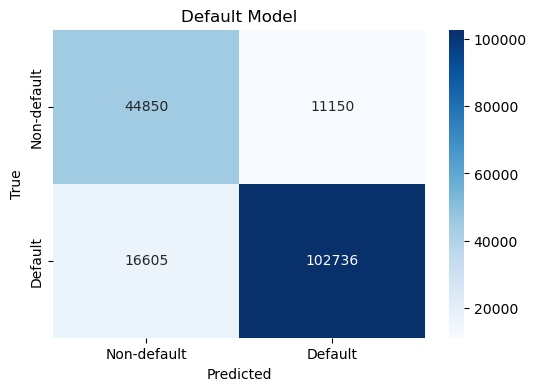

23/08/17 15:30:06 WARN TaskSetManager: Stage 1817 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:30:07 WARN TaskSetManager: Stage 1828 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:30:08 WARN TaskSetManager: Stage 1842 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:30:08 WARN TaskSetManager: Stage 1845 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:30:09 WARN TaskSetManager: Stage 1848 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:30:10 WARN TaskSetManager: Stage 1851 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:30:10 WARN TaskSetManager: Stage 1854 contains a task of very large size (2970 KiB). The maximum recommended task size is 10

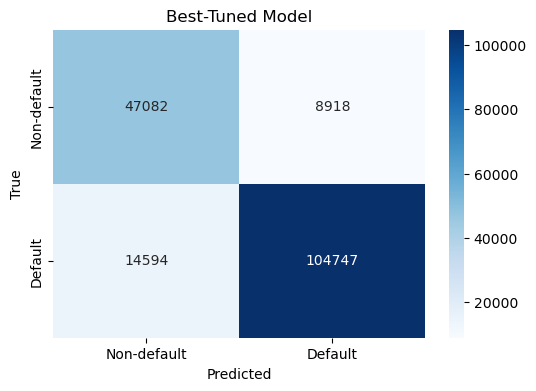

23/08/17 15:30:15 WARN TaskSetManager: Stage 1868 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:30:16 WARN TaskSetManager: Stage 1879 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:30:17 WARN TaskSetManager: Stage 1893 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:30:18 WARN TaskSetManager: Stage 1896 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:30:18 WARN TaskSetManager: Stage 1899 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:30:19 WARN TaskSetManager: Stage 1902 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/17 15:30:19 WARN TaskSetManager: Stage 1905 contains a task of very large size (2970 KiB). The maximum recommended task size is 10

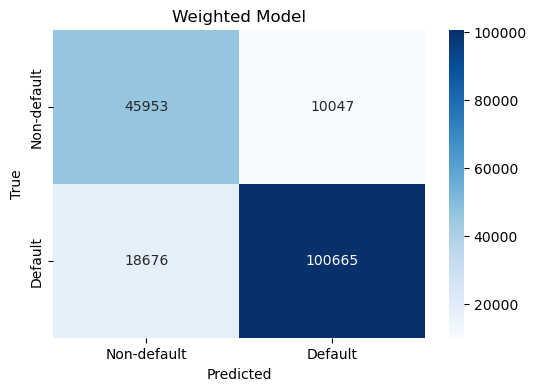

Evaluation Results:
Metric              Default Model       Best-Tuned Model    Weighted Model      
AUC                 0.925574            0.935696            0.926280            
AreaUnderPR         0.961361            0.965924            0.961830            
Sensitivity         0.860861            0.877712            0.843507            
Specificity         0.800893            0.840750            0.820589            
Precision           0.649512            0.648251            0.631410            
Recall              0.860861            0.877712            0.843507            
F1-Score            0.740399            0.745729            0.722208            
Accuracy            0.841708            0.865907            0.836188            


In [28]:
# Evaluate models using the evaluate_model function
evaluation_results_default = evaluate_model(model_default, test, 'Default Model')  # Use the 'test' dataset
evaluation_results_best_tuned = evaluate_model(best_tuned_model, FT_test, 'Best-Tuned Model')  # Use the 'FT_test' dataset
evaluation_results_weighted = evaluate_model(weighted_lr_model, FT_test, 'Weighted Model')  # Use the 'FT_test' dataset

# Print evaluation results for all models side by side
print("Evaluation Results:")
print(f"{'Metric':<20}{'Default Model':<20}{'Best-Tuned Model':<20}{'Weighted Model':<20}")
print("=" * 100)

for metric in evaluation_results_default.keys():
    default_value = evaluation_results_default[metric]
    best_tuned_value = evaluation_results_best_tuned[metric]
    weighted_value = evaluation_results_weighted[metric]
    print(f"{metric:<20}{default_value:<20.6f}{best_tuned_value:<20.6f}{weighted_value:<20.6f}")


## Decision Tree Model

### Default Model

###  Fine-Tuning 

### Evaluation

## Random Forest Model

### Default Model

###  Fine-Tuning 

### Evaluation

## Multilayer perceptron Model

### Default Model

###  Fine-Tuning 

### Evaluation

# Final comparison between Models